# Hysteresis Loops Fitting

In [1]:
import sys
sys.path.append('../../')
# sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")
sys.path.append('../../src')

In [2]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.viz.layout import subfigures

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
# from m3_learning.nn.Fitter1D.Fitter1D_new import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads data

In [3]:
# Specify the filename and the path to save the file
filename = 'data_raw_unmod.h5'
save_path = "./Data"

data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path)

# print the contents of the file
dataset.print_be_tree()

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ R

## Performs SHO fits

In [4]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit()

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed results at /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed res

/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


## Visualize LSQF fit results

In [5]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

# instantiate the dataset object
dataset = BE_Dataset(data_path)

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/hysteresis_comparison.png
./Figures/hysteresis_comparison.svg


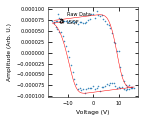

In [6]:
BE_viz.hysteresis_comparison(data = ['LSQF'])

## Neural Network Fits

In [7]:
dataset.loop_param_scaler

StandardScaler()

In [8]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [9]:
dataset.hysteresis_scaler

In [10]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.optimizers.TrustRegion import TRCG
import torch.optim as optim


data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
# V = np.swapaxes(np.atleast_2d(dataset.get_voltage), 0, 1).astype(np.float64)


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
                            voltage[:,0].squeeze(), # x data
#                             V.squeeze(),
                            1, # input channels
                            9, # output parameters
                            dataset.loop_param_scaler,
                            loops_scaler=dataset.hysteresis_scaler)

# instantiate the model
model = Model(model_, dataset, training=True, model_basename="SHO_Fitter_original_data")

from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(data.reshape(-1,96), test_size=0.2, random_state=42, shuffle=True)

X_train = np.atleast_3d(X_train)

optimizer = {
    "name": "TRCG", 
    "optimizer": TRCG,
    "closure_size": 1,
    "cgopttol": 1e-3,
    "c0tr": 0.2,
    "c1tr": 0.25,
    "c2tr": 0.75,
    "t1tr": 0.75,
    "t2tr": 2.0,
    "radius_max": 5.0,  
    "radius_initial": 1.0,
    "radius" : 1.0,
    "device": "cuda",
    "ADAM_epochs": 500}


train = True

if train:
    # fits the model
    model.fit(
        X_train,
        1024,
        optimizer=optimizer,
        epochs = 600,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
Using GPU A100-SXM4-40GB
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam
epoch : 1/600, recon loss = 0.15932465
--- 1.3989462852478027 seconds ---
Epoch 1, Learning Rate: 0.001
Adam
epoch : 2/600, recon loss = 0.10540325
--- 0.1104123592376709 seconds ---
Epoch 2, Learning Rate: 0.001
Adam
epoch : 3/600, recon loss = 0.07236160
--- 0.11023998260498047 seconds ---
Epoch 3, Learning Rate: 0.001
Adam
epoch : 4/600, recon loss = 0.05490667
--- 0.10823750495910645 seconds ---
Epoch 4, Learning Rate: 0.001
Adam
epoch : 5/600, recon loss = 0.04736421
--- 0.11182284355163574 seconds ---
Epoch 5, Learning Rate: 0.001
Adam
epoch : 6/600, recon loss = 0.04256225
--- 0.10750198364257812 seconds ---
Epoch 6, Learning Rate: 0.001
Adam
epoch : 7/600, recon loss = 0.03869602
--- 0.1068871021270752 seconds ---
Epoch 7, Learning Rate: 0.001
Adam
epoch : 8/600, recon loss = 0.03554474
--- 0.10638093948364258 seconds ---
Epoch 8, Learning Rate: 0.001
Adam
epoch : 9/600, recon loss = 0.06933050
--- 0.10659503936767578 seconds ---
Epoch 9, Learning Rate: 0.001
Adam
epoch : 

Adam
epoch : 76/600, recon loss = 0.01186767
--- 0.10683584213256836 seconds ---
Epoch 76, Learning Rate: 0.001
Adam
epoch : 77/600, recon loss = 0.01184208
--- 0.10683870315551758 seconds ---
Epoch 77, Learning Rate: 0.001
Adam
epoch : 78/600, recon loss = 0.01182740
--- 0.10676217079162598 seconds ---
Epoch 78, Learning Rate: 0.001
Adam
epoch : 79/600, recon loss = 0.01188235
--- 0.10646796226501465 seconds ---
Epoch 79, Learning Rate: 0.001
Adam
epoch : 80/600, recon loss = 0.01200589
--- 0.10676169395446777 seconds ---
Epoch 80, Learning Rate: 0.001
Adam
epoch : 81/600, recon loss = 0.01170689
--- 0.10620927810668945 seconds ---
Epoch 81, Learning Rate: 0.001
Adam
epoch : 82/600, recon loss = 0.01164363
--- 0.10662317276000977 seconds ---
Epoch 82, Learning Rate: 0.001
Adam
epoch : 83/600, recon loss = 0.01151652
--- 0.10609912872314453 seconds ---
Epoch 83, Learning Rate: 0.001
Adam
epoch : 84/600, recon loss = 0.01148369
--- 0.10617685317993164 seconds ---
Epoch 84, Learning Rate

Adam
epoch : 150/600, recon loss = 0.00917618
--- 0.10599732398986816 seconds ---
Epoch 150, Learning Rate: 0.001
Adam
epoch : 151/600, recon loss = 0.00917560
--- 0.10658836364746094 seconds ---
Epoch 151, Learning Rate: 0.001
Adam
epoch : 152/600, recon loss = 0.00926434
--- 0.10686016082763672 seconds ---
Epoch 152, Learning Rate: 0.001
Adam
epoch : 153/600, recon loss = 0.00925382
--- 0.10613346099853516 seconds ---
Epoch 153, Learning Rate: 0.001
Adam
epoch : 154/600, recon loss = 0.00919905
--- 0.106201171875 seconds ---
Epoch 154, Learning Rate: 0.001
Adam
epoch : 155/600, recon loss = 0.00915850
--- 0.10763359069824219 seconds ---
Epoch 155, Learning Rate: 0.001
Adam
epoch : 156/600, recon loss = 0.00911408
--- 0.10645914077758789 seconds ---
Epoch 156, Learning Rate: 0.001
Adam
epoch : 157/600, recon loss = 0.00911010
--- 0.10586786270141602 seconds ---
Epoch 157, Learning Rate: 0.001
Adam
epoch : 158/600, recon loss = 0.00909832
--- 0.10674071311950684 seconds ---
Epoch 158, 

Adam
epoch : 223/600, recon loss = 0.00871153
--- 0.10962605476379395 seconds ---
Epoch 223, Learning Rate: 0.001
Adam
epoch : 224/600, recon loss = 0.00864780
--- 0.10613632202148438 seconds ---
Epoch 224, Learning Rate: 0.001
Adam
epoch : 225/600, recon loss = 0.00869086
--- 0.10698819160461426 seconds ---
Epoch 225, Learning Rate: 0.001
Adam
epoch : 226/600, recon loss = 0.00866908
--- 0.10642647743225098 seconds ---
Epoch 226, Learning Rate: 0.001
Adam
epoch : 227/600, recon loss = 0.00864591
--- 0.10667061805725098 seconds ---
Epoch 227, Learning Rate: 0.001
Adam
epoch : 228/600, recon loss = 0.00865919
--- 0.10620427131652832 seconds ---
Epoch 228, Learning Rate: 0.001
Adam
epoch : 229/600, recon loss = 0.00881725
--- 0.10614442825317383 seconds ---
Epoch 229, Learning Rate: 0.001
Adam
epoch : 230/600, recon loss = 0.00873718
--- 0.10597729682922363 seconds ---
Epoch 230, Learning Rate: 0.001
Adam
epoch : 231/600, recon loss = 0.00882363
--- 0.10642743110656738 seconds ---
Epoch 

Adam
epoch : 295/600, recon loss = 0.00818486
--- 0.10611581802368164 seconds ---
Epoch 295, Learning Rate: 0.001
Adam
epoch : 296/600, recon loss = 0.00829978
--- 0.10579538345336914 seconds ---
Epoch 296, Learning Rate: 0.001
Adam
epoch : 297/600, recon loss = 0.00820972
--- 0.10586023330688477 seconds ---
Epoch 297, Learning Rate: 0.001
Adam
epoch : 298/600, recon loss = 0.00820812
--- 0.10611486434936523 seconds ---
Epoch 298, Learning Rate: 0.001
Adam
epoch : 299/600, recon loss = 0.00815021
--- 0.10611581802368164 seconds ---
Epoch 299, Learning Rate: 0.001
Adam
epoch : 300/600, recon loss = 0.00814737
--- 0.10591959953308105 seconds ---
Epoch 300, Learning Rate: 0.001
Adam
epoch : 301/600, recon loss = 0.00818392
--- 0.1060326099395752 seconds ---
Epoch 301, Learning Rate: 0.001
Adam
epoch : 302/600, recon loss = 0.00836244
--- 0.10561442375183105 seconds ---
Epoch 302, Learning Rate: 0.001
Adam
epoch : 303/600, recon loss = 0.00820970
--- 0.10564494132995605 seconds ---
Epoch 3

Adam
epoch : 367/600, recon loss = 0.00762768
--- 0.10794401168823242 seconds ---
Epoch 367, Learning Rate: 0.001
Adam
epoch : 368/600, recon loss = 0.00758121
--- 0.10755634307861328 seconds ---
Epoch 368, Learning Rate: 0.001
Adam
epoch : 369/600, recon loss = 0.00756980
--- 0.1070406436920166 seconds ---
Epoch 369, Learning Rate: 0.001
Adam
epoch : 370/600, recon loss = 0.00757151
--- 0.10710859298706055 seconds ---
Epoch 370, Learning Rate: 0.001
Adam
epoch : 371/600, recon loss = 0.00770287
--- 0.10691332817077637 seconds ---
Epoch 371, Learning Rate: 0.001
Adam
epoch : 372/600, recon loss = 0.00778674
--- 0.10620975494384766 seconds ---
Epoch 372, Learning Rate: 0.001
Adam
epoch : 373/600, recon loss = 0.00788388
--- 0.10604095458984375 seconds ---
Epoch 373, Learning Rate: 0.001
Adam
epoch : 374/600, recon loss = 0.00760721
--- 0.10638189315795898 seconds ---
Epoch 374, Learning Rate: 0.001
Adam
epoch : 375/600, recon loss = 0.00758802
--- 0.10658597946166992 seconds ---
Epoch 3

Adam
epoch : 439/600, recon loss = 0.00719133
--- 0.10618734359741211 seconds ---
Epoch 439, Learning Rate: 0.001
Adam
epoch : 440/600, recon loss = 0.00724178
--- 0.10581660270690918 seconds ---
Epoch 440, Learning Rate: 0.001
Adam
epoch : 441/600, recon loss = 0.00720296
--- 0.1094062328338623 seconds ---
Epoch 441, Learning Rate: 0.001
Adam
epoch : 442/600, recon loss = 0.00713808
--- 0.1075594425201416 seconds ---
Epoch 442, Learning Rate: 0.001
Adam
epoch : 443/600, recon loss = 0.00717083
--- 0.1073305606842041 seconds ---
Epoch 443, Learning Rate: 0.001
Adam
epoch : 444/600, recon loss = 0.00714460
--- 0.10744738578796387 seconds ---
Epoch 444, Learning Rate: 0.001
Adam
epoch : 445/600, recon loss = 0.00720128
--- 0.10769033432006836 seconds ---
Epoch 445, Learning Rate: 0.001
Adam
epoch : 446/600, recon loss = 0.00720219
--- 0.10792684555053711 seconds ---
Epoch 446, Learning Rate: 0.001
Adam
epoch : 447/600, recon loss = 0.00716467
--- 0.10799884796142578 seconds ---
Epoch 447

Trust Region CG
epoch : 511/600, recon loss = 0.00638385
--- 4.256038427352905 seconds ---
Epoch 511, Learning Rate: 0.001
Trust Region CG
epoch : 512/600, recon loss = 0.00636323
--- 3.803243398666382 seconds ---
Epoch 512, Learning Rate: 0.001
Trust Region CG
epoch : 513/600, recon loss = 0.00638197
--- 4.36871075630188 seconds ---
Epoch 513, Learning Rate: 0.001
Trust Region CG
epoch : 514/600, recon loss = 0.00632375
--- 2.9483931064605713 seconds ---
Epoch 514, Learning Rate: 0.001
Trust Region CG
epoch : 515/600, recon loss = 0.00631456
--- 2.8843512535095215 seconds ---
Epoch 515, Learning Rate: 0.001
Trust Region CG
epoch : 516/600, recon loss = 0.00630867
--- 2.3743386268615723 seconds ---
Epoch 516, Learning Rate: 0.001
Trust Region CG
epoch : 517/600, recon loss = 0.00630087
--- 2.270073175430298 seconds ---
Epoch 517, Learning Rate: 0.001
Trust Region CG
epoch : 518/600, recon loss = 0.00629790
--- 2.699554204940796 seconds ---
Epoch 518, Learning Rate: 0.001
Trust Region C

Trust Region CG
epoch : 578/600, recon loss = 0.00610883
--- 4.747066020965576 seconds ---
Epoch 578, Learning Rate: 0.001
Trust Region CG
epoch : 579/600, recon loss = 0.00608773
--- 3.049499034881592 seconds ---
Epoch 579, Learning Rate: 0.001
Trust Region CG
epoch : 580/600, recon loss = 0.00608049
--- 3.639277935028076 seconds ---
Epoch 580, Learning Rate: 0.001
Trust Region CG
epoch : 581/600, recon loss = 0.00607719
--- 2.8307175636291504 seconds ---
Epoch 581, Learning Rate: 0.001
Trust Region CG
epoch : 582/600, recon loss = 0.00607957
--- 3.0584123134613037 seconds ---
Epoch 582, Learning Rate: 0.001
Trust Region CG
epoch : 583/600, recon loss = 0.00607434
--- 2.7898783683776855 seconds ---
Epoch 583, Learning Rate: 0.001
Trust Region CG
epoch : 584/600, recon loss = 0.00607249
--- 2.649397611618042 seconds ---
Epoch 584, Learning Rate: 0.001
Trust Region CG
epoch : 585/600, recon loss = 0.00607110
--- 2.502800941467285 seconds ---
Epoch 585, Learning Rate: 0.001
Trust Region 

In [11]:
import torch
X_train = torch.atleast_3d(torch.tensor(X_train))


train_pred_recon, train_pred_params_scaled, train_pred_params = model.predict(
    X_train,
    1024,
    translate_params=False
)

In [12]:
train_pred_recon.shape
train_pred_params_scaled.shape
train_pred_params.shape

torch.Size([11520, 9])

In [13]:
X_train[1000].shape

torch.Size([96, 1])

In [14]:
voltage.shape

(96, 1)

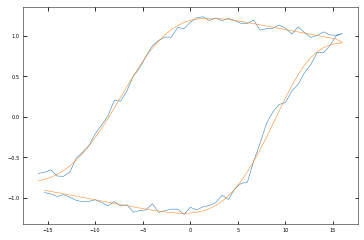

In [15]:
i = np.random.randint(0, X_train.shape[0])

import matplotlib.pyplot as plt
plt.plot(voltage, X_train[i])
plt.plot(voltage, np.atleast_2d(train_pred_recon[i]))

### Evaluate the Neural Network Results

/home/alk224/workspace/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/viz.py:999: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(true).float()


./Figures/Figure_X_NN_validation_Train.png
./Figures/Figure_X_NN_validation_Train.svg


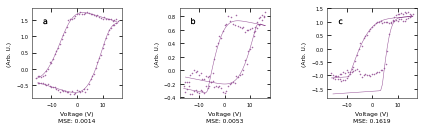

In [16]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Train",
)

./Figures/Figure_X_NN_validation_Test.png
./Figures/Figure_X_NN_validation_Test.svg


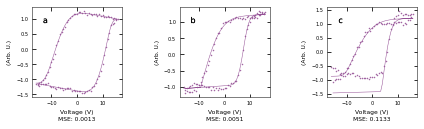

In [17]:
X_test = torch.atleast_3d(torch.tensor(X_test))

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Test",
)

### Calculate the MSE

In [18]:
data_ = (torch.atleast_3d(torch.tensor(data.reshape(-1, 96))), X_test, X_train)
labels = ["Full Data", "Test Data", "Train Data"]

model.print_mse(data_, labels)

Full Data Mean Squared Error: 0.0061
Test Data Mean Squared Error: 0.0059
Train Data Mean Squared Error: 0.0061


## Comparison of LSQF and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/Figure_XX_LSQF_NN_bmw_comparison.png
./Figures/Figure_XX_LSQF_NN_bmw_comparison.svg


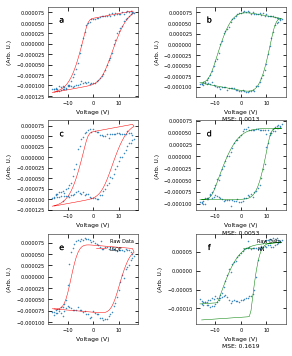

In [19]:
n = 1

data = ("LSQF", "NN")
# names = ["LSQF", "NN"]

BE_viz.hysteresis_comparison(
    data,
    model=model,
    filename="Figure_XX_LSQF_NN_bmw_comparison",
)

### Statistics of the Results for Training, Validation, and Entire Dataset

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/Figure_XX_Violin.png
./Figures/Figure_XX_Violin.svg


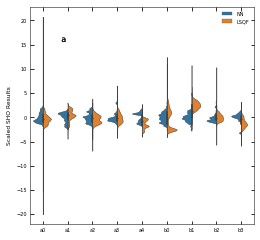

In [20]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

BE_viz.violin_plot_comparison_hysteresis(model,
                                         torch.atleast_3d(torch.tensor(data.reshape(-1, 96))),
                                         filename="Figure_XX_Violin") 

### Color Maps of Parameters

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/Figure_XX_NN_Hysteresis_Maps.png
./Figures/Figure_XX_NN_Hysteresis_Maps.svg


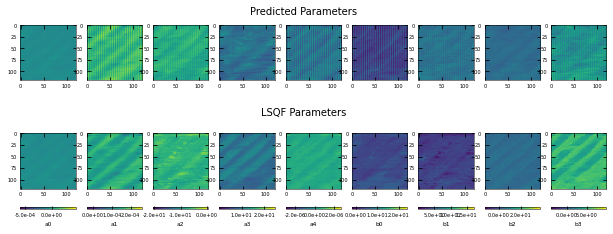

In [80]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
data = torch.atleast_3d(torch.tensor(data.reshape(-1, 96)))

pred_recon, pred_params_scaled, pred_params = model.predict(
    data,
    1024,
    translate_params=False
)

BE_viz.hysteresis_maps(pred_params, filename="Figure_XX_NN_Hysteresis_Maps")